In [2]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import time
import warnings

from premade_funcs import load_data

from sklearn.neural_network import MLPClassifier
import sklearn.metrics

Just load_and_plot_data code here:

In [3]:
data_dir = os.path.abspath("data_fashion/")
test_x, train_x, train_y_df, valid_x, valid_y_df = load_data(data_dir)

Contents of train_x.csv: arr of shape (2102, 784)
Contents of valid_x.csv: arr of shape (600, 784)
Contents of test_x.csv: arr of shape (600, 784)


## Pre-set values to put into MLPClassifier

In [4]:
n_runs = 4

max_iter_per_run = 1000
tr_balacc_arr = np.ones(n_runs) # Pre allocate with arbitrary values, just so code doesnt break
va_balacc_arr = np.ones(n_runs)

In [ ]:
for run_id, random_state in enumerate(range(n_runs)):
    
    start_time_sec = time.time()
    mlp = MLPClassifier(
        hidden_layer_sizes=1,   #At MOST 1 hidden layer per spec.
        activation='relu',
        alpha=0.0001,
        tol=1e-5,
        max_iter=max_iter_per_run,
        random_state=random_state,
        solver='lbfgs', batch_size=10000,
        )
        
    with warnings.catch_warnings(record=True) as warn_list:
        mlp.fit(train_x, train_y_df['class_uid'])
    elapsed_time_sec = time.time() - start_time_sec
    mlp.did_converge = True if len(warn_list) == 0 else False
    train_pred = mlp.predict(train_x)
    val_pred = mlp.predict(valid_x)

    # compute the acc rate on the training set and test set
    tr_acc = sklearn.metrics.balanced_accuracy_score(train_y_df['class_uid'], train_pred)

    va_acc = sklearn.metrics.balanced_accuracy_score(valid_y_df['class_uid'], val_pred)
    
    tr_balacc_arr[run_id] = tr_acc
    va_balacc_arr[run_id] = va_acc
    
    print(
        'run %d/%d done after %5.1f sec | %13s after %3d iter | tr acc %.3f | te acc %.3f' % ( 
        run_id + 1, n_runs, elapsed_time_sec,
        'yes converged' if mlp.did_converge else 'NOT converged',
        max_iter_per_run,
        tr_acc, va_acc))

c:\Users\avtar\micromambaenv\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\avtar\micromambaenv\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.16666666666666666


c:\Users\avtar\micromambaenv\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


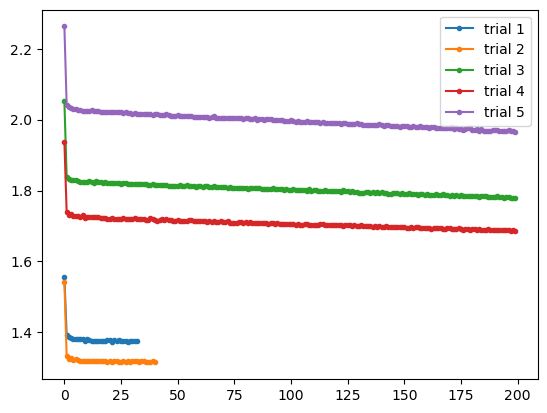

In [7]:
for trial in [1, 2, 3, 4, 5]:
    mlp_1hidden_batchsize25 = sklearn.neural_network.MLPClassifier(
        hidden_layer_sizes=[1],
        activation='relu',
        solver='sgd',
        learning_rate_init=0.05,
        random_state=trial,
        batch_size=25,
        )
    
    # Fit the model to training data
    mlp_1hidden_batchsize25.fit(train_x, train_y_df['class_uid'])
    
    # Visualize the trace of the loss
    plt.plot(mlp_1hidden_batchsize25.loss_curve_, '.-', label='trial %d' % trial)
    
plt.legend();

tr_pred = mlp_1hidden_batchsize25.predict(train_x)
tr_acc = sklearn.metrics.balanced_accuracy_score(train_y_df['class_uid'], tr_pred)

print(tr_acc)